<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li><li><span><a href="#Анализ-результатов" data-toc-modified-id="Анализ-результатов-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Анализ результатов</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Требуется построить модель со значением метрики качества *F1* не меньше 0.75. 

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [3]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn. metrics import f1_score
import spacy
matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 



In [ ]:
try:
    data = pd.read_csv('C:\\Users\\katrusya\\Desktop\\Датасеты для Яндекс практикума\\toxic_comments(1).csv', index_col=0)
except:
    print('could not open the file toxic_comments')

In [3]:
data.sample()

,text,toxic
101137,"""\n\nI undid your change, since the """"Suspecte...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Немного разгрузим ресурс, заменим тип данных в столбце 'toxic'

In [5]:
data['toxic'] = data['toxic'].astype('int8')

У нас два столбца без пропусков. Текст на латинице. Посмотрим на баланс токсичных и нетоксичных текстов

In [6]:
percentage_of_toxic = data['toxic'].value_counts()[0]/data['toxic'].count()*100
percentage_of_non_toxic = data['toxic'].value_counts()[1]/data['toxic'].count()*100
print('Процент 0-твитов', round(percentage_of_toxic),'\n','Процент 1-твитов', round(percentage_of_non_toxic))

Процент 0-твитов 90 
 Процент 1-твитов 10


0    143106
1     16186
Name: toxic, dtype: int64


<AxesSubplot:xlabel='toxic', ylabel='count'>

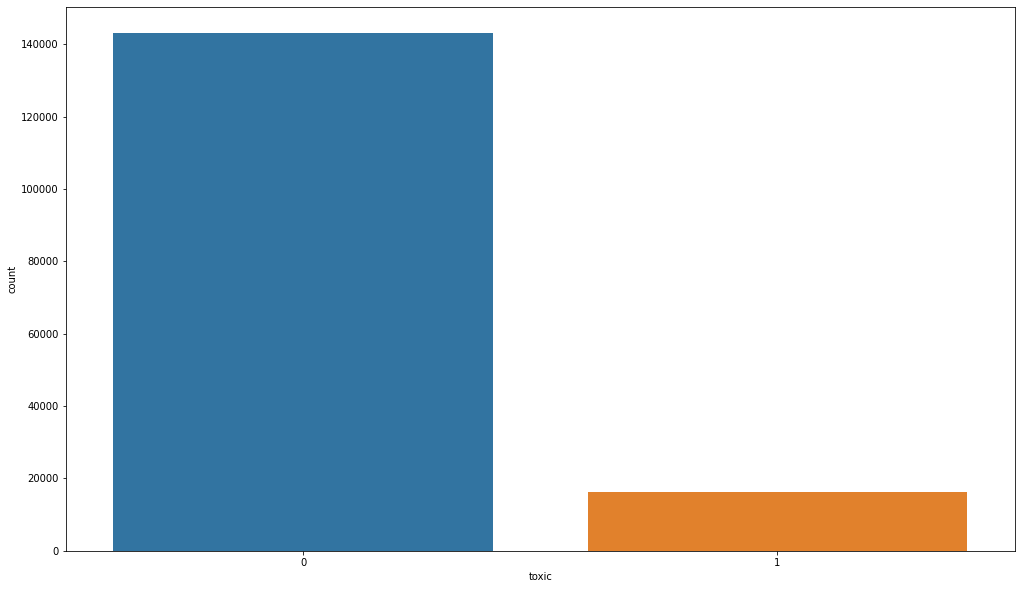

In [7]:
print(data['toxic'].value_counts())
z = data['toxic'].value_counts()[0]
one = data['toxic'].value_counts()[1]
plt.figure(figsize=(17, 10))
sns.countplot(x='toxic', data=data)

Большой перевес в сторону токсичных твитов. Нужна балансировка классов.

Чищу текст функцией to_clear

In [8]:
def to_clear(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text_c = ' '.join(text.split())
    return text_c

применяю функцию

In [9]:
data['text'] = data['text'].apply(to_clear)
data

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0
...,...,...
159446,and for the second time of asking when your vi...,0
159447,you should be ashamed of yourself that is a ho...,0
159448,spitzer umm theres no actual article for prost...,0
159449,and it looks like it was actually you who put ...,0


Организуем функцию POS - тег

In [10]:
from nltk.corpus import wordnet

In [11]:

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

Создадим объект класса WordNetLemmatizer()

In [12]:
lemm = WordNetLemmatizer()

Напишем функцию лемматизации

In [13]:
def to_lemm(text):
    text_l = [lemm.lemmatize(ob, get_wordnet_pos(ob)) for ob in nltk.word_tokenize(text)]
    return ' '.join(text_l)

Пробуем лемматизировать

In [ ]:
data['text'] = data['text'].apply(to_lemm)

In [ ]:
data

Разобъём данные на target и features

In [ ]:
target = data['toxic']
features = data['text']

Разделим на обучающую и тестовую выборку

In [ ]:
random = 42

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=random)

Загрузим стоп-слова

In [ ]:
nltk.download('stopwords')

Нас интересуют стоп-слова на английском

In [ ]:
s_w = set(stopwords.words('english'))

Оценим важность. Определим величину TF-IDF

In [ ]:
counter = TfidfVectorizer(stop_words=s_w)

In [ ]:
features_train_tfidf = counter.fit_transform(features_train)


In [ ]:
features_test_tfidf = counter.transform(features_test)

**Была произведена загрузка данных, пропусков не выявлено. Данные содержат два столбца: текст на английском языке и целочисленные данные. Тип данных столбца 'toxic' заменили с int_64 на int_8 для экономии ресурса. Был выявлен дисбаланс твитов 0:1 как 9:1. Данные столбца 'text' были лемматезированы. В данных был выделен целевой признак, произведено разбиение на тренировочную и тестовую выборку, в пропорции 3:1. Произведена очистка от стоп-слов и рассчитан TF-IDF.**

## Обучение

Для обучения используем случайный лес, логистическую регрессию и дерево решений. Не забываем о дисбалансе. Качество отслеживаем по метрике f1.

In [ ]:
my_cv = 5

### Случайный лес

In [ ]:
param_rfc = {'n_estimators':(60,81,10),
    'max_depth':(40,61,10), 'min_samples_leaf':(1, 2)}
model_rfc = RandomForestClassifier(class_weight = 'balanced', random_state=random)
clf_forest = GridSearchCV(model_rfc, param_rfc, cv=my_cv, scoring='f1')
clf_forest.fit(features_train_tfidf, target_train)

In [ ]:
print('Лучшие параметры для случайного леса', clf_forest.best_params_)

In [ ]:
print('Качество случайного леса', round(clf_forest.best_score_, 2))


### Логистическая регрессия

In [ ]:
model_regress = LogisticRegression(fit_intercept=True, solver='liblinear',
                                class_weight ='balanced', random_state=random, C =10)
scores_regress = cross_val_score(model_regress, features_train_tfidf, target_train, cv=8, scoring='f1').mean()



In [ ]:
print("Качество логистической регрессии", round(scores_regress, 2))

### Дерево решений

In [ ]:
param_dt = {'max_depth':(145, 151, 2), 'min_samples_split':[4, 6, 2]}
model_dt = DecisionTreeClassifier(class_weight = 'balanced', min_samples_leaf = 1, random_state=random)
clf_dt = GridSearchCV(model_dt, param_dt, cv=my_cv, scoring='f1')
clf_dt.fit(features_train_tfidf, target_train)

In [ ]:
clf_dt.best_params_

In [ ]:
print('f1 для дерева решений', round(clf_dt.best_score_, 2))

### Проверка на адекватность

Чтобы проверить модель на адекватность, найдём значение f1 для модели, все значения которой будут равны 1.

In [ ]:
adequacy_check_mod = [1 for i in range(len(target_test))]
print(round(f1_score(target_test.reset_index(drop=True),(adequacy_check_mod)),2))

### Анализ результатов

In [ ]:
df = [['0.76'], ['0.65'],['0.49']]
model = ["Regression", "DecisionTree", "RandomForest"]

In [ ]:
pd.DataFrame(data=df, index=model, columns=["f1-cross"])

Была попытка локального бустинга, но она оканчивалась "dead kernel", поэтому были выбраны модели регрессии, случайного леса и дерева решений. Тот самый случай, когда лучшие результаты оказались у регрессии. Только они удовлетворяют условию задачи.

### Тестирование модели

In [ ]:
model_regress.fit(features_train_tfidf, target_train)

In [ ]:
model_regress.fit(features_train_tfidf, target_train)
reg_pred = model_regress.predict(features_test_tfidf)
print("ошибка для регрессии при тестировании составила:", round(f1_score(target_test, reg_pred),2))

## Выводы

**После выгрузки данных был заменён тип данных столбца 'toxic'с int_64 на int_8 для экономии ресурса. Пропусков выявлено не было. Зато был обнаружен дисбаланс твитов 0:1 как 9:1. Данные столбца 'text' были лемматезированы. В данных был выделен целевой признак, произведено разбиение на тренировочную и тестовую выборку, в пропорции 3:1. Произведена очистка от стоп-слов и рассчитан TF-IDF.   
В качестве моделей были выбраны регрессия, дерево решений и случайный лес. Проверялись модели кросс-валидацией.
Лучший и единственно удовлетворяющий условию результат показала логистическая регрессия. F1 на кросс валидации - 0.76, на тестовой выборке - 0.76.   
Константная модель показала результат 0.18, что подтверждает адекватность всех трёх моделей.   
Рекомендую заказчику логистическую регрессию как самую результативную и быструю в обучении модель.**